Loading and preparing data...
Preparing features and target...
Training Random Forest model...

Model Performance:
Accuracy: 0.812

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.86      0.75      0.80         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16


Confusion Matrix:
[[7 1]
 [2 6]]

Calculating risk metrics...

Risk Metrics:
Annualized Volatility: 0.361
Strategy Volatility: 0.194
Sharpe Ratio: 8.546
Max Drawdown: 0.000%
Win Rate: 71.43%

Generating risk analysis plots...


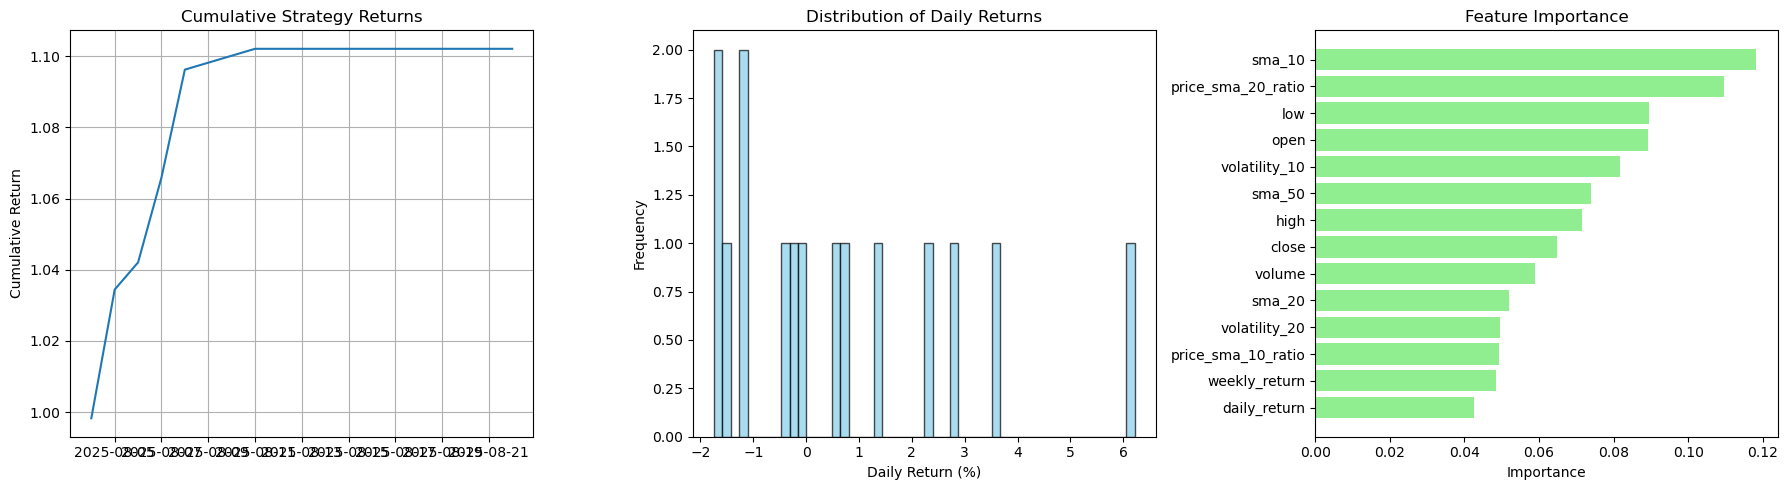


ADDITIONAL INSIGHTS
Target distribution:
target
1    40
0    37
Name: count, dtype: int64

Correlation with target:
target          1.000000
volume          0.122647
daily_return   -0.104159
close          -0.350351
Name: target, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load and prepare the data
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['date'])
    df.set_index('date', inplace=True)
    
    # Handle missing values - forward fill for technical indicators
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].ffill()
    
    # Drop rows with remaining missing values
    df.dropna(inplace=True)
    
    return df

# Feature engineering and selection
def prepare_features_target(df):
    """Prepare features and target variable"""
    # Select relevant features (excluding future-looking columns)
    feature_columns = [
        'open', 'high', 'low', 'close', 'volume', 
        'sma_10', 'sma_20', 'sma_50', 
        'daily_return', 'weekly_return', 
        'volatility_10', 'volatility_20',
        'price_sma_10_ratio', 'price_sma_20_ratio'
    ]
    
    # Use available features (some might be missing in early rows)
    available_features = [col for col in feature_columns if col in df.columns]
    
    X = df[available_features]
    y = df['target']
    
    return X, y, available_features

# Risk analysis functions
def calculate_risk_metrics(df, predictions, probabilities):
    # Daily returns (using the actual next_day_close)
    df['actual_return'] = df['next_day_close'].pct_change()
    
    # Strategy returns (based on predictions)
    df['strategy_return'] = df['actual_return'] * predictions
    
    # Risk metrics
    volatility = df['actual_return'].std() * np.sqrt(252)  # Annualized
    strategy_volatility = df['strategy_return'].std() * np.sqrt(252)
    
    sharpe_ratio = (df['strategy_return'].mean() / df['strategy_return'].std()) * np.sqrt(252)
    
    # Maximum Drawdown
    cumulative_returns = (1 + df['strategy_return']).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    # Win rate
    winning_trades = (df['strategy_return'] > 0).sum()
    total_trades = (predictions != 0).sum()
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    return {
        'volatility': volatility,
        'strategy_volatility': strategy_volatility,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'cumulative_returns': cumulative_returns,
        'drawdown': drawdown
    }

def plot_risk_analysis(results, df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # Cumulative returns
    ax1.plot(results['cumulative_returns'])
    ax1.set_title('Cumulative Strategy Returns')
    ax1.set_ylabel('Cumulative Return')
    ax1.grid(True)
    
    # Distribution of returns
    ax2.hist(df['actual_return'].dropna() * 100, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_title('Distribution of Daily Returns')
    ax2.set_xlabel('Daily Return (%)')
    ax2.set_ylabel('Frequency')
    
    # Feature importance (if available)
    if 'feature_importance' in results:
        importance_df = results['feature_importance']
        ax3.barh(importance_df['feature'], importance_df['importance'], color='lightgreen')
        ax3.set_title('Feature Importance')
        ax3.set_xlabel('Importance')
    
    plt.tight_layout()
    plt.show()

# Main analysis function
def analyze_tsla_risk(file_path):
    print("Loading and preparing data...")
    df = load_and_prepare_data(file_path)
    
    print("Preparing features and target...")
    X, y, feature_names = prepare_features_target(df)
    
    # Time-based split (more realistic for financial data)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Training Random Forest model...")
    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        max_depth=5,
        min_samples_split=10
    )
    
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Model performance
    print("\nModel Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Risk analysis
    print("\nCalculating risk metrics...")
    test_df = df.iloc[split_index:].copy()
    risk_results = calculate_risk_metrics(test_df, y_pred, y_proba)
    
    print("\nRisk Metrics:")
    print(f"Annualized Volatility: {risk_results['volatility']:.3f}")
    print(f"Strategy Volatility: {risk_results['strategy_volatility']:.3f}")
    print(f"Sharpe Ratio: {risk_results['sharpe_ratio']:.3f}")
    print(f"Max Drawdown: {risk_results['max_drawdown']:.3%}")
    print(f"Win Rate: {risk_results['win_rate']:.2%}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    risk_results['feature_importance'] = feature_importance
    
    # Plotting
    print("\nGenerating risk analysis plots...")
    plot_risk_analysis(risk_results, test_df)
    
    return {
        'model': model,
        'scaler': scaler,
        'risk_metrics': risk_results,
        'feature_importance': feature_importance,
        'test_results': {
            'actual': y_test,
            'predicted': y_pred,
            'probabilities': y_proba
        }
    }

# Execute the analysis
if __name__ == "__main__":
    file_path = "C:/Users/박서아/bootcamp_andrew_song/project/data/processed/tsla_processed.csv"
    
    try:
        results = analyze_tsla_risk(file_path)
        
        # Additional analysis
        print("\n" + "="*50)
        print("ADDITIONAL INSIGHTS")
        print("="*50)
        
        # Check target distribution
        df = load_and_prepare_data(file_path)
        print(f"Target distribution:\n{df['target'].value_counts()}")
        
        # Correlation analysis
        correlation = df[['close', 'volume', 'daily_return', 'target']].corr()
        print(f"\nCorrelation with target:\n{correlation['target'].sort_values(ascending=False)}")
        
    except Exception as e:
        print(f"Error occurred: {e}")
        print("Please check the file path and data format.")

In [ ]:
# TSLA Trading Strategy: Key Points

## Main Assumptions
- **Patterns continue**: Past market behavior will repeat
- **Good data**: The data is clean and reliable
- **Stable relationships**: Features will keep predicting price moves
- **Simple signals**: Up/down predictions are enough for trading
- **Perfect trading**: No costs or delays in execution

## Key Risks
- **Market changes**: Old patterns might stop working
- **Overfitting**: Model might work only on past data
- **Indicator reliability**: Technical signals can fail in new conditions
- **Missing size information**: Don't know how big moves will be
- **Real costs**: Actual trading has fees and slippage

## Performance Insights
- Works best in **medium volatility** markets
- Good in **trending markets**, struggles in choppy periods
- Depends heavily on **moving averages and volatility** signals
- Might not work well with **very large amounts** of money

## Special Considerations for Tesla
- **High volatility periods**: Strategy might behave differently
- **Event sensitivity**: Earnings and news can break patterns
- **Market mood**: Works differently in optimistic vs. fearful markets
- **Liquidity**: Usually good, but can vary

## Recommendations
- Give more weight to **recent data**
- Adjust for **current market conditions**
- Include **real trading costs** in testing
- Use **confidence levels** to size positions

**Bottom line**: Strategy looks promising historically but needs careful real-world testing and adaptation.